****************************************************************
# Machine Learning-based Event Selection
****************************************************************

In this tutorial we present the data preprocessing and handling for the application of machine learning modelf from the Scikit-Learn library. This library is also called the swiss army knife of machine learning. A wide variety of models and preprocessing tools is implemented and carefully maintained.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, mixture
import cait as ai
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path = 'test_data/'
fnames = ['labeled_001']
filepath = ['{}{}.h5'.format(path, f) for f in fnames]

channel = 0

## Data Preprocessing and Training

The data preprocessing, handling and evaluation for sklearn models is done with the EvaluationTools class. 

In [3]:
et = ai.EvaluationTools()

We can add events to the instance from the HDF5 files. Here we have to specify which data is input to the machine learning models. Standard options are the main parameters and the raw time series of the event. However, further below we have a short section bout how to add individual features.

In [4]:
et.add_events_from_file(file=filepath[0],
                    channel=channel,
                    which_data='mainpar',
                    )

We then split the dataset in a training and test set. This is a standard for all machine learning models and should always be done, to optimize the bias-variance tradeoff of our trained models.

In [5]:
et.split_test_train(test_size=0.60)

We can access the training data and labels with the getter function. 

In [7]:
_, _, X_train, _, y_train = et.get_train()

Now we pick a model from the sklearn library, in this case a random forest, i.e. an ensemble of decision trees. Each tree is fit to a subset of the training set and applies repeatedly splits to its data subset, such that it optimizes a given metric in the emerging chunks of the dataset. Typical metrics are entropy for classification tasks and variance for regression. The splits are always applied to the single feature, that has the worst pre-split value in the defined metric.

In [6]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=7)

clf_rf.fit(X_train, 
           y_train)

We then add its predictions to the instance of EvaluationTools.

In [9]:
et.add_prediction(pred_method='RFC', 
                  pred=clf_rf.predict(et.features), 
                  true_labels=True)

We can repeat this procedure for different models, e.g. a support vector machine. The support vector machines is a linear method that finds a hyperplane in a higher dimensional space with maximal margin to features of different classes in feature space. Often the features are first subject to a non-linear kernel, to achieve non-linear separation in feature space.

In [10]:
clf_svm = svm.SVC()

clf_svm.fit(X_train, 
            y_train)

et.add_prediction(pred_method='SVM', 
                  pred=clf_svm.predict(et.features), 
                  true_labels=True)

Sklearn also has a variety of unsupervised machine learning models, e.g. Gaussian Mixture Models. This is a maximul likelihood fit with several gaussian templates in feature space, typically calcualted with the expectation maximization algorithm.

In [15]:
gmm = mixture.GaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                              covariance_type='full').fit(et.features)

gmm_pred = gmm.predict(et.features)
et.add_prediction(pred_method='GMM', pred=gmm_pred)

Gaussian Mixture Models are the same, but calculate Bayesian estimators for all parameters, including a (in our case non-informative) prior.

In [13]:
bgmm = mixture.BayesianGaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                                           covariance_type='full').fit(et.features)

bgmm_pred = bgmm.predict(et.features)
et.add_prediction(pred_method='BGMM', 
                  pred=bgmm_pred)

## Evaluation

Within the EvaluationTools class, there are several methods to visualize labels and predictions. At first, there is a wrapper around the sklearn class for a t-Stochastic Neighbourhood Embedding. This method constructs a two-dimensional representation of the data points, that retains small euclidean distances between data points (clusters) as good as possible.

Within a Jupyter Notebook, the interactive functionality of Pyplot does not work. If the function is called in the command line, the opened window responds to hovering and displays the event index of the data point. In the future, there will also be the functionality to click on a data point and by that open a window with the time series of the event.

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


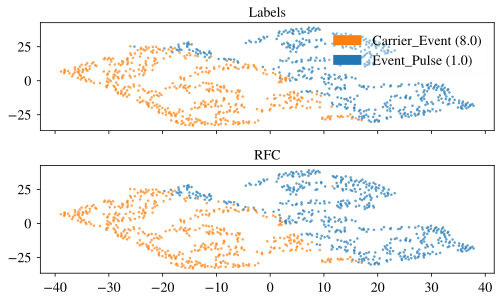

In [16]:
et.plt_pred_with_tsne(pred_methods=['RFC'], what='all', verb=True)

We see that the tSNE achieves a very good separation of carrier and absorber events. We also see, that the RF classifier performs very well in classifying the data, as almost all data points in the two plots match in color.

The second implemented method for visualization is the PCA, that we know already from previous notebooks. Here the 

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


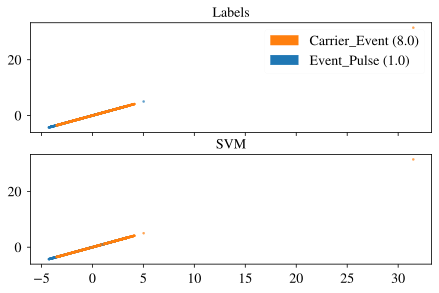

In [17]:
et.plt_pred_with_pca(pred_methods=['SVM'], xy_comp=(0,1), what='all', verb=True)

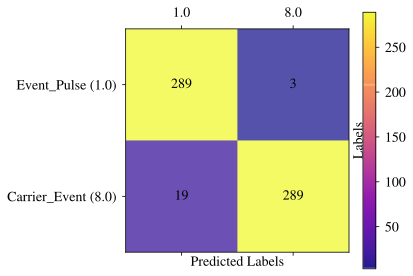

In [18]:
et.confusion_matrix_pred('RFC', what='test', rotation_xticklabels=0, force_xlabelnbr=True, figsize= (6,4))

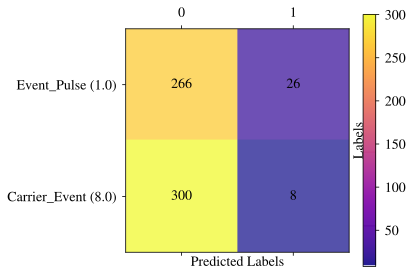

In [19]:
et.confusion_matrix_pred('BGMM', what='test', rotation_xticklabels=0, force_xlabelnbr=True, figsize= (6,4))

## Individual Features

.. code:: python

    dh = ai.DataHandler()
    dh.set_filepath(path_h5=path,
                    fname=fnames[0],
                    appendix=False)
                   
    features = dh.get('events', 'pca_projection')[0]
    
    # either hand the data from the beginning right away
    et.add_events_from_file(file=filepath[0],
                        channel=channel,
                        which_data=features,
                        )
                        
    # or overwrite the existing data at a later point
    et.set_data(features)

## Predictions on Real Data

In [21]:
et_pred = ai.EvaluationTools()

et_pred.add_events_from_file(file='test_data/test_001.h5',
                        channel=channel,
                        which_data='mainpar',
                        )

et_pred.set_scaler(et.scaler)

predictions = clf_rf.predict(et_pred.features)

et_pred.add_prediction('RFC', predictions, true_labels=True)
et_pred.save_prediction('RFC',
                       path=path,
                       fname='test_001',
                       channel=channel)

Saved Predictions as CSV file.


In [22]:
dh = ai.DataHandler()
dh.set_filepath(path_h5=path,
                fname='test_001',
                appendix=False)

dh.import_predictions(model='RFC',
                   path_predictions=path,
                   only_channel=channel)

DataHandler Instance created.
Added RFC Predictions.


In [23]:
mh = ai.ModelHandler(model_type='RFC')    

mh.add_model(channel=channel,
             model=clf_rf)

mh.add_scaler(scaler=et.scaler,
              channel=channel)

# save
mh.save(path='test_data')

MLModel Instance created.
Added scaler for channel 0.
Write info about this instance: test set size 60
Save Model to test_data/RFC_run01_Test.


.. code:: python

    mh = pickle.load(open('test_data/RFC_run01_Test', 'rb+'))